## Calculating the R peak using derivative and threshold value
The code and the function for the derivative and R peak calculation are located in RpeakUsingDerivative.
In this notebook we will just visualize and test the functions and finally calculate HR using the computed RR interval.


### Import Section 

In [2]:
import sys
import os
# go up one directory from notebooks/ → project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
import numpy as np
from src import RpeakUsingDerivative, PreProcessing

from scipy.signal import fftconvolve

import matplotlib.pyplot as plt

In [26]:
#Parameters
record_path = os.path.join(os.getcwd(), "..", "data", "100")
starting_sample = 5
ending_sample = 90000
channel_size =1 #Only take the voltage value of the MLII, V5. 

#Take input
record,_ =PreProcessing.record_annotation(record_path,starting_sample,ending_sample,channel_size)
fs = record.fs
sample = np.array(record.p_signal.tolist())
print("60s sample size:- ", 60*fs)


60s sample size:-  21600


### Signal PreProcessing
Applying the bandpass filter on the original signal to remove noise


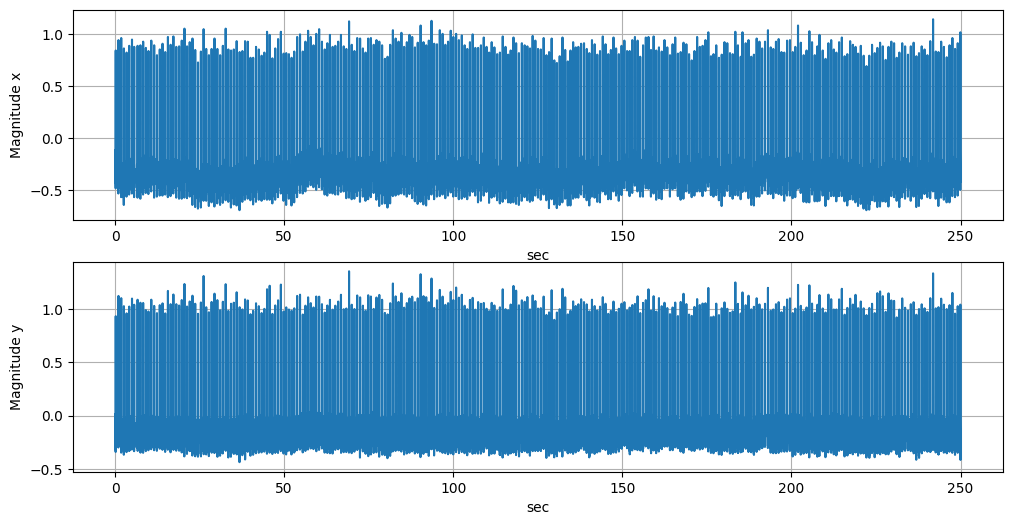

In [27]:

#filter parameters
low_freq = 0.5
high_freq = 40
N = 500

#convolution
h = PreProcessing.windowedimpulseResponse(low_freq, high_freq, fs, N)
x = sample[:,0] #taking theMLII as the input data
y_n = fftconvolve(x, h, mode='same')

#plot the y_n values
fig, axs = plt.subplots(2,1,figsize=(12,6))
time_axis = np.arange(len(x))
time_axis = time_axis[:] / fs

axs[0].plot(time_axis,x)
axs[0].set_ylabel("Magnitude x")
axs[0].set_xlabel("sec")
axs[0].grid(True)

axs[1].plot(time_axis,y_n)
axs[1].set_ylabel("Magnitude y")
axs[1].set_xlabel("sec")
axs[1].grid(True)
plt.show()





### Extracting the R_peak index using Derivative and Threshold values.
The RR peak times are calculated using the RpeakUsingDerivative.py code. For more details on calculation have a look at the .py file.

During calculation I have skiped some samples after a peak detection else the algorithm will detect the same R peak as multiple peak values.
From internet search, I found that the least distance between two RR interval is 200ms. Below that it is dangerous and heart cannot hold for long.
So 200ms corresponds to fs * 0.2, which is the exact number of samples skipped by the algorithm.






In [28]:
import src.RpeakUsingDerivative as RpeakUsingDerivative
import importlib
importlib.reload(RpeakUsingDerivative)

#Peak Calculation parameters
threshold = 0.3 #in mv
x = np.arange(len(sample[:,0])) #The x axis value for the derivative
y = y_n
samples_to_skip = int(0.2 * fs)

print(samples_to_skip)


#Calculating the peak index value
RP_index = RpeakUsingDerivative.calcRpeakIndex(x,y,threshold) 

RP_time = RP_index[:]/fs
print("The peak values are observed at time(s):- ",RP_time)
print(len(RP_time))

72
The peak values are observed at time(s):-  [1.75000000e-01 9.86111111e-01 1.80000000e+00 2.58888889e+00
 3.38055556e+00 4.16944444e+00 4.98611111e+00 5.63888889e+00
 6.63333333e+00 7.47500000e+00 8.28611111e+00 9.08055556e+00
 9.85000000e+00 1.06888889e+01 1.15444444e+01 1.23638889e+01
 1.31944444e+01 1.40166667e+01 1.48111111e+01 1.56027778e+01
 1.64000000e+01 1.72222222e+01 1.80888889e+01 1.89138889e+01
 1.96972222e+01 2.04833333e+01 2.12638889e+01 2.20527778e+01
 2.28611111e+01 2.36805556e+01 2.45083333e+01 2.53527778e+01
 2.61555556e+01 2.69333333e+01 2.77333333e+01 2.85222222e+01
 2.93777778e+01 3.02222222e+01 3.10472222e+01 3.18500000e+01
 3.26833333e+01 3.34777778e+01 3.42611111e+01 3.50833333e+01
 3.59305556e+01 3.68111111e+01 3.76333333e+01 3.84083333e+01
 3.92111111e+01 4.00250000e+01 4.08222222e+01 4.16583333e+01
 4.24888889e+01 4.33138889e+01 4.41250000e+01 4.49083333e+01
 4.56916667e+01 4.65027778e+01 4.73444444e+01 4.81777778e+01
 4.90027778e+01 4.98138889e+01 5.058888

### Calculating the HeartBeat using the calculated R peak index values.

In [29]:
r_interval = np.zeros(len(RP_time)-1)
for i in range (len(RP_time)-1):
    r_interval[i] = RP_time[i+1] - RP_time[i]
mean = np.sum(r_interval) / len(r_interval)
HR = 60/mean
print("The calculated HR is:- ",HR)
    

The calculated HR is:-  74.23423423423424


In [31]:
import numpy as np
import os

# Path to save file
save_path = "../data/processed"
os.makedirs(save_path, exist_ok=True)  # create folder if it doesn't exist

# Save the R-peak results
np.savez(os.path.join(save_path, "r_peaks.npz"),
         rr_intervals=r_interval,
         r_peaks_time=RP_time,
         r_peaks_index=RP_index)

print("R-peaks saved successfully!")


R-peaks saved successfully!
